Spatial Data Science 

Homework 2

Mariam Hovhannisyan

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import shapely

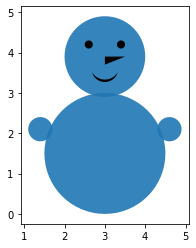

In [65]:
#1. Draw a snowman with shapely or/and GeoPandas smile
body1 =Point(3,1.5).buffer(1.5)
body2 =Point(3,3.9).buffer(1)
hand1 = Point(1.4,2.1).buffer(.3)
hand2 = Point(4.6,2.1).buffer(.3)
body = gpd.GeoDataFrame({"geometry" : [body1, body2, hand1, hand2]})
ax =body.plot(alpha=.9)

eye1 = Point(2.6,4.2).buffer(.1)
eye2 = Point(3.4,4.2).buffer(.1)
nose = Polygon([(3,3.9), (3,3.7), (3.5,3.9)])
a = Point(3,3.7).buffer(.37)
b = Point(3,3.6).buffer(.33)
smile = b.difference(a)
face = gpd.GeoDataFrame({"geometry" : [eye1, eye2, nose, smile]})

face.plot(ax =ax, color="black")
plt.show()

In [ ]:
#2. Use the grid cell polygons of Yerevan city and compute the distance between the centroid 
#of the grid cell with highest parking area and the centroid of all of Yerevan city.
# LEMME JUST USE YOUR CODE, THANKS!
from pyproj import CRS
from shapely.ops import cascaded_union

city = ox.geocode_to_gdf("Yerevan, Armenia")
city = ox.projection.project_gdf(city)
#ax = yerevan.plot()
circle = Point(44.3989, 40.1492).buffer(4*0.00899928)
c = gpd.GeoSeries(circle)
crs = CRS.from_epsg(4326)

df1 = gpd.GeoDataFrame({'geometry': c, 'df1':[1]}, crs=crs)
df = df1.to_crs(city.crs)
city_union = gpd.overlay(df, city, how='union')
#city_union.plot()
polygons = [city_union['geometry'].iloc[0], city_union['geometry'].iloc[1], city_union['geometry'].iloc[2]]
boundary = gpd.GeoSeries(cascaded_union(polygons))
#boundary.plot(color = 'red')

yerevan = gpd.GeoDataFrame({'geometry': boundary}, crs=city.crs)
geometry = yerevan['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=500)

yerevan['coords'] = yerevan['geometry'].apply(lambda x: x.representative_point().coords[:])
yerevan['coords'] = [coords[0] for coords in yerevan['coords']]
polylist = [p for p in geometry_cut]


polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = yerevan.geometry.crs
west, south, east, north = yerevan.unary_union.bounds

tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.geometries_from_place("Yerevan, Armenia", tags)
parkings = gdf[(gdf["amenity"] == "parking") & \
                  (gdf["geometry"].geom_type == "Polygon")].dropna(axis=1, how="any")
parkings.reset_index(inplace=True, drop=True)

parking_shp = parkings[['geometry']]
parking_shp= parking_shp.copy()
parking_shp.geometry = parking_shp.geometry.to_crs(polyframe.crs)

parking_shp['area'] = parking_shp.geometry.area
cells_parkingcounts = gpd.sjoin(polyframe, parking_shp, op='intersects')
parkingcounts = cells_parkingcounts.groupby(cells_parkingcounts.index)['area'].sum()

polyframe['area'] = parkingcounts
polyframe['area'].fillna(0, inplace=True)

#__________________________________
crs = CRS.from_epsg(4326)
polycopy = polyframe.copy()
yerevan1=yerevan.copy()

yerevan1=yerevan1.to_crs(crs)
polycopy =  polycopy.to_crs(crs)
cell1 = polycopy[polycopy['area']==polycopy['area'].max()]

cell1.centroid.distance(yerevan1.centroid)

In [151]:
#3.Take a driver (partnerId column) of your choice from the taxi vehicle GPS data set, 
#compute the distances from all GPS points of that driver to the geometric center of its GPS positions, 
#or to the Yerevan polygon centroid, and plot the resulting DISTRIBUTION of distances.
data = pd.read_csv('Yerevan_gps_data.csv',header=0, index_col=0, nrows=2*10**6)
geometry = [Point(xy) for xy in zip(data.lon, data.lat)] 
crs = polyframe.crs
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
gdf.tail()

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (44.44599 40.17727)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (44.57209 40.17507)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (44.57210 40.17505)


In [168]:
gdf['partnerId'].unique()

,createdAt,partnerId,lat,lon,status,geometry
1999995,2019-03-20 09:35:28,31939,40.211296,44.471706,0,POINT (44.47171 40.21130)
1999996,2019-03-20 09:35:47,31939,40.211324,44.471693,0,POINT (44.47169 40.21132)
1999997,2019-03-20 09:35:56,31939,40.211312,44.471718,0,POINT (44.47172 40.21131)
1999998,2019-03-20 09:36:13,31939,40.211312,44.471717,0,POINT (44.47172 40.21131)
1999999,2019-03-20 09:36:24,31939,40.211313,44.471714,0,POINT (44.47171 40.21131)


In [167]:
partner = gdf[gdf['partnerId']==66]
partner.tail()

,createdAt,partnerId,lat,lon,status,geometry
91909,2019-03-31 17:52:18,66,40.189428,44.517867,1,POINT (44.51787 40.18943)
91910,2019-03-31 17:52:50,66,40.189179,44.517378,1,POINT (44.51738 40.18918)
91911,2019-03-31 17:53:02,66,40.189318,44.516684,1,POINT (44.51668 40.18932)
91912,2019-03-31 17:53:18,66,40.189340,44.516600,0,POINT (44.51660 40.18934)
91913,2019-03-31 17:53:26,66,40.189376,44.516254,0,POINT (44.51625 40.18938)


getting the distribution of distances between a partner's points and its centroid would be 
more informative in understanding their performance, wheres in case of the city center we 
won't be able to compare the perfrmances amongs partners

In [222]:
poly2 = Polygon([[p.x, p.y] for p in partner['geometry']])
dist=partner.geometry.distance(poly2.centroid)

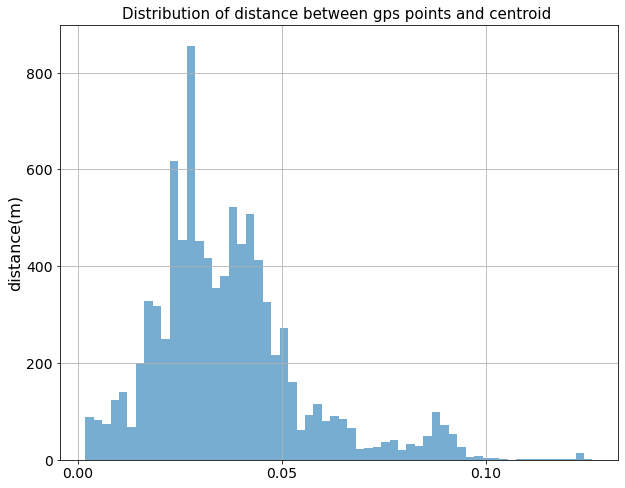

In [239]:
fig, ax = plt.subplots(figsize = (10,8))
dist.plot(kind = "hist", density = False, bins = 60, alpha = 0.6) 
ax.set_ylabel("distance(m)", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_title("Distribution of distance between gps points and centroid ", fontsize = 15)
ax.grid(True)
plt.show()